After merging the given datasets, I was able to wrangle the data by reducing repetitive entries and columns that had too much missing information. Thereafter, I created a Train-Test split to then form a Logistic Regression and Data Tree  Model. Once I checked the metrics, I took the Data Tree Model onto wrangle the Test Group and created my prediction column for the Water Pump Challenge.

In [1]:
    !pip install category_encoders==2.*
    !pip install pandas_profiling==2.*

In [2]:
import category_encoders as ce
from category_encoders import OrdinalEncoder, OneHotEncoder
from pandas_profiling import ProfileReport
from scipy.stats import randint, uniform
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, plot_confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, RandomizedSearchCV,cross_val_score, validation_curve
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#Download Data from Google drive

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/Kaggle"

In [5]:
%cd /content/gdrive/MyDrive/Kaggle
!ls

/content/gdrive/MyDrive/Kaggle
model_rf_80			   train_features.csv
model_rf_Water_Pump		   train_labels.csv
OTTOLINO_WATER_PUMP_CHALLENGE.csv  WATER_PUMP_CHALLENGE.csv
sample_submission.csv		   Water_Pump_model_rfrs
test_features.csv


#Download Data from Google drive

In [6]:
train_features = pd.read_csv('train_features.csv')
train_features.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,454,50.0,2013-02-27,Dmdd,2092,DMDD,35.426020,-4.227446,Narmo,0,Internal,Bashnet Kati,Manyara,21,1,Babati,Bashinet,160,True,GeoData Consultants Ltd,Water Board,NaN,True,1998,gravity,gravity,gravity,water board,user-group,pay per bucket,per bucket,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
1,510,0.0,2011-03-17,Cmsr,0,Gove,35.510074,-5.724555,Lukali,0,Internal,Lukali,Dodoma,1,6,Bahi,Lamaiti,0,True,GeoData Consultants Ltd,VWC,NaN,True,0,india mark ii,india mark ii,handpump,vwc,user-group,never pay,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump
2,14146,0.0,2011-07-10,Kkkt,0,KKKT,32.499866,-9.081222,Mahakama,0,Lake Rukwa,Chawalikozi,Mbeya,12,6,Mbozi,Ndalambo,0,True,GeoData Consultants Ltd,VWC,NaN,False,0,other,other,other,vwc,user-group,never pay,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,other,other
3,47410,0.0,2011-04-12,NaN,0,NaN,34.060484,-8.830208,Shule Ya Msingi Chosi A,0,Rufiji,Shuleni,Mbeya,12,7,Mbarali,Chimala,0,True,GeoData Consultants Ltd,VWC,NaN,True,0,gravity,gravity,gravity,vwc,user-group,pay monthly,monthly,soft,good,insufficient,insufficient,river,river/lake,surface,communal standpipe,communal standpipe
4,1288,300.0,2011-04-05,Ki,1023,Ki,37.032690,-6.040787,Kwa Mjowe,0,Wami / Ruvu,Ngholong,Morogoro,5,1,Kilosa,Chakwale,120,True,GeoData Consultants Ltd,VWC,NaN,True,1997,other,other,other,vwc,user-group,pay when scheme fails,on failure,salty,salty,enough,enough,shallow well,shallow well,groundwater,other,other


In [7]:
train_labels = pd.read_csv('train_labels.csv')
train_labels.head()

,id,status_group
0,454,functional
1,510,functional
2,14146,non functional
3,47410,non functional
4,1288,non functional


In [8]:
train_features.shape

(47520, 40)

#Merge Train features and labels

In [9]:
train = pd.merge(pd.read_csv('train_features.csv'),pd.read_csv('train_labels.csv'))
train

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,454,50.0,2013-02-27,Dmdd,2092,DMDD,35.426020,-4.227446,Narmo,0,Internal,Bashnet Kati,Manyara,21,1,Babati,Bashinet,160,True,GeoData Consultants Ltd,Water Board,NaN,True,1998,gravity,gravity,gravity,water board,user-group,pay per bucket,per bucket,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,510,0.0,2011-03-17,Cmsr,0,Gove,35.510074,-5.724555,Lukali,0,Internal,Lukali,Dodoma,1,6,Bahi,Lamaiti,0,True,GeoData Consultants Ltd,VWC,NaN,True,0,india mark ii,india mark ii,handpump,vwc,user-group,never pay,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional
2,14146,0.0,2011-07-10,Kkkt,0,KKKT,32.499866,-9.081222,Mahakama,0,Lake Rukwa,Chawalikozi,Mbeya,12,6,Mbozi,Ndalambo,0,True,GeoData Consultants Ltd,VWC,NaN,False,0,other,other,other,vwc,user-group,never pay,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,other,other,non functional
3,47410,0.0,2011-04-12,NaN,0,NaN,34.060484,-8.830208,Shule Ya Msingi Chosi A,0,Rufiji,Shuleni,Mbeya,12,7,Mbarali,Chimala,0,True,GeoData Consultants Ltd,VWC,NaN,True,0,gravity,gravity,gravity,vwc,user-group,pay monthly,monthly,soft,good,insufficient,insufficient,river,river/lake,surface,communal standpipe,communal standpipe,non functional
4,1288,300.0,2011-04-05,Ki,1023,Ki,37.032690,-6.040787,Kwa Mjowe,0,Wami / Ruvu,Ngholong,Morogoro,5,1,Kilosa,Chakwale,120,True,GeoData Consultants Ltd,VWC,NaN,True,1997,other,other,other,vwc,user-group,pay when scheme fails,on failure,salty,salty,enough,enough,shallow well,shallow well,groundwater,other,other,non functional
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47515,68525,1000.0,2011-03-20,Dhv,327,DWE,36.367112,-8.774761,Kwa Mbayambaya,0,Rufiji,Bwawani,Morogoro,5,4,Ulanga,Mtimbira,255,True,GeoData Consultants Ltd,Water Board,Mtimbira,True,1995,gravity,gravity,gravity,wug,user-group,pay monthly,monthly,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe,functional
47516,11980,1000.0,2011-03-10,Danida,1743,DANID,34.531524,-9.769604,none,0,Lake Nyasa,Mlangali Ndani,Iringa,11,5,Ludewa,Mlangali,35,True,GeoData Consultants Ltd,VWC,DANIDA,False,1988,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,seasonal,seasonal,spring,spring,groundwater,communal standpipe,communal standpipe,functional
47517,35778,0.0,2011-03-13,Omar Ally,-13,Omar Ally,38.974416,-5.420823,Kwa Omar Ally,0,Pangani,Sokoni,Tanga,4,5,Pangani,Pangani Mashariki,1000,False,GeoData Consultants Ltd,Private operator,NaN,False,2005,other,other,other,private operator,commercial,never pay,never pay,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,other,other,non functional
47518,49444,0.0,2012-10-31,Rwssp,0,WEDECO,34.316586,-3.107161,Muungano,0,Lake Victoria,Ijosho,Shinyanga,17,6,Meatu,Sakasaka,0,True,GeoData Consultants Ltd,WUG,None,True,0,nira/tanira,nira/tanira,handpump,wug,user-group,never pay,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional


In [10]:
train.shape

(47520, 41)

#Run and explore Profile Report

In [11]:
Report = ProfileReport(train, minimal=True).to_notebook_iframe()

Summarize dataset:   0%|          | 0/49 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

#Merge train_features and train_labels. 

#Parse date_recorded column.

In [12]:
train = pd.merge(pd.read_csv('train_features.csv', na_values=[0,-2.000000e-08],
                              parse_dates=['date_recorded']),
                 pd.read_csv('train_labels.csv', na_values=[0,-2.000000e-08]))

In [13]:
train['id'] 

0          454.0
1          510.0
2        14146.0
3        47410.0
4         1288.0
          ...   
47515    68525.0
47516    11980.0
47517    35778.0
47518    49444.0
47519    23812.0
Name: id, Length: 47520, dtype: float64

In [14]:
train['id'].isnull().sum()

1

In [15]:
#mask = (train['id'] == 0)
#train = train[~mask]

In [16]:
train['id'] = train['id'].fillna(0)

In [17]:
train['id'] = train['id'].astype('int', errors='ignore')

In [18]:
train.dtypes

id                                int64
amount_tsh                      float64
date_recorded            datetime64[ns]
funder                           object
gps_height                      float64
installer                        object
longitude                       float64
latitude                        float64
wpt_name                         object
num_private                     float64
basin                            object
subvillage                       object
region                           object
region_code                       int64
district_code                   float64
lga                              object
ward                             object
population                      float64
public_meeting                   object
recorded_by                      object
scheme_management                object
scheme_name                      object
permit                           object
construction_year               float64
extraction_type                  object


In [19]:
train['public_meeting'].value_counts()

True     40743
False     4088
Name: public_meeting, dtype: int64

#Wrangle Data

In [20]:
#columns that are duplicates or not positively correlated with target
drop_col = ['quantity_group','num_private']#,'basin','region_code',	'district_code', 'source_type','source_class','extraction_type_group','extraction_type_class','management_group','payment_type','waterpoint_type_group','quality_group','scheme_management','num_private','amount_tsh']

In [21]:
def wrangle(df):


#make 'id' index
  df.set_index('id', inplace=True)

# Extract components from date_recorded, then drop the original column
  df['year_recorded'] = df.date_recorded.dt.year
  df['month_recorded'] = df.date_recorded.dt.month
  df['day_recorded'] = df.date_recorded.dt.day

#Engineer new target column
  df['pump_age'] = df['year_recorded'] - df['construction_year']
  
#Drop datetime column
  df.drop(columns=['date_recorded'],inplace=True)
  
#Constant columns will not help our model 
  constant_columns = [col for col in df.columns if df[col].nunique() ==1]
  df = df.drop(columns=constant_columns)

# Drop HCCs
  threshold = 100
  drop_hcc = [col for col in df.select_dtypes('object').columns
              if df[col].nunique() > threshold]
  df.drop(columns=drop_hcc, inplace=True)

  #self-inspection to drop duplicate columns seemed to be more accurate
  df.drop(columns=drop_col, inplace=True)

  #reexplore this drop due to too many NaNs
  df.drop(columns=['gps_height'],inplace=True)

#Turn string true/false classification targets into numerical binary classification  
  df['public_meeting'] = df['public_meeting'].astype(str).str.replace('True','1').str.replace('False','0').astype(float)
  df['permit'] = df['permit'].astype(str).str.replace('True','1').str.replace('False','0').astype(float)

#represent missing data as NaNs
  df['longitude'] = df['longitude'].replace(0, np.nan)
  df['latitude'] = df['latitude'].replace(0, np.nan)
  df['construction_year'] = df['construction_year'].replace(0, np.nan)
  df['pump_age'] = df['pump_age'].replace(0, np.nan)

  df = df.fillna(df.median())
              
  return df

train = wrangle(train)

train.shape




(47520, 32)

In [22]:
train['permit'].value_counts()

1.0    33467
0.0    14053
Name: permit, dtype: int64

In [23]:
train['public_meeting'].value_counts()

1.0    43432
0.0     4088
Name: public_meeting, dtype: int64

In [24]:
train

,amount_tsh,longitude,latitude,basin,region,region_code,district_code,population,public_meeting,scheme_management,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,year_recorded,month_recorded,day_recorded,pump_age
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
454,50.0,35.426020,-4.227446,Internal,Manyara,21,1.0,160.0,1.0,Water Board,1.0,1998.0,gravity,gravity,gravity,water board,user-group,pay per bucket,per bucket,soft,good,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,functional,2013,2,27,15.0
510,250.0,35.510074,-5.724555,Internal,Dodoma,1,6.0,150.0,1.0,VWC,1.0,2000.0,india mark ii,india mark ii,handpump,vwc,user-group,never pay,never pay,soft,good,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional,2011,3,17,13.0
14146,250.0,32.499866,-9.081222,Lake Rukwa,Mbeya,12,6.0,150.0,1.0,VWC,0.0,2000.0,other,other,other,vwc,user-group,never pay,never pay,soft,good,enough,shallow well,shallow well,groundwater,other,other,non functional,2011,7,10,13.0
47410,250.0,34.060484,-8.830208,Rufiji,Mbeya,12,7.0,150.0,1.0,VWC,1.0,2000.0,gravity,gravity,gravity,vwc,user-group,pay monthly,monthly,soft,good,insufficient,river,river/lake,surface,communal standpipe,communal standpipe,non functional,2011,4,12,13.0
1288,300.0,37.032690,-6.040787,Wami / Ruvu,Morogoro,5,1.0,120.0,1.0,VWC,1.0,1997.0,other,other,other,vwc,user-group,pay when scheme fails,on failure,salty,salty,enough,shallow well,shallow well,groundwater,other,other,non functional,2011,4,5,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68525,1000.0,36.367112,-8.774761,Rufiji,Morogoro,5,4.0,255.0,1.0,Water Board,1.0,1995.0,gravity,gravity,gravity,wug,user-group,pay monthly,monthly,soft,good,enough,river,river/lake,surface,communal standpipe,communal standpipe,functional,2011,3,20,16.0
11980,1000.0,34.531524,-9.769604,Lake Nyasa,Iringa,11,5.0,35.0,1.0,VWC,0.0,1988.0,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,seasonal,spring,spring,groundwater,communal standpipe,communal standpipe,functional,2011,3,10,23.0
35778,250.0,38.974416,-5.420823,Pangani,Tanga,4,5.0,1000.0,0.0,Private operator,0.0,2005.0,other,other,other,private operator,commercial,never pay,never pay,soft,good,insufficient,shallow well,shallow well,groundwater,other,other,non functional,2011,3,13,6.0


#Explore Dataframe columns

In [25]:
train.isnull().sum()

amount_tsh                  0
longitude                   0
latitude                    0
basin                       0
region                      0
region_code                 0
district_code               0
population                  0
public_meeting              0
scheme_management        3102
permit                      0
construction_year           0
extraction_type             0
extraction_type_group       0
extraction_type_class       0
management                  0
management_group            0
payment                     0
payment_type                0
water_quality               0
quality_group               0
quantity                    0
source                      0
source_type                 0
source_class                0
waterpoint_type             0
waterpoint_type_group       0
status_group                0
year_recorded               0
month_recorded              0
day_recorded                0
pump_age                    0
dtype: int64

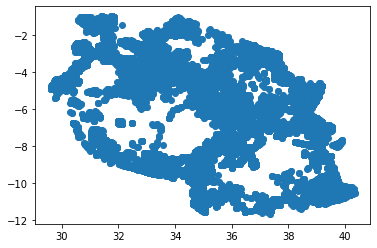

In [26]:
plt.scatter(train['longitude'],train['latitude'])
plt.show()

#Split Date
- We want to predict 'status_group', so that will become our target.
- Turn our target into a binary based off of water pumps being 'functional'

In [27]:
train['status_group'].value_counts()
#Target is almost evenly balanced

functional                 25802
non functional             18252
functional needs repair     3466
Name: status_group, dtype: int64

In [28]:
#Turn 'status_group' into binary classification
train['status_group'] = np.where(train['status_group'] == 'functional', 0, 1)

In [66]:
train['status_group'].value_counts()

0    25802
1    21718
Name: status_group, dtype: int64

In [29]:
target = 'status_group'
y = train[target]
X = train.drop(columns=target)

*Train-test split will only be used for our model_lr. It will not be needed for the tree models, because we will execute a cross-validation.*

In [30]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.2, random_state=42)

In [31]:
print('BASELINE ACCURACY:', y.value_counts(normalize=True).max() )
#Not using y_train because our best model will be using cross-validation

BASELINE ACCURACY: 0.5429713804713805


#Build Decision Tree pipeline

- *Fit model to X_train, y_train*


In [32]:
model_dt = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(strategy='median'),
    StandardScaler(),
    DecisionTreeClassifier(random_state=42, max_depth=10)
    )

model_dt.fit(X_train, y_train);

#Check Decision Tree Metrics

- print accuracy scores for training/val

In [33]:
print('model_dt accuracy score for training:', accuracy_score(y_train, model_dt.predict(X_train)))
print('model_dt accuracy score for val:', accuracy_score(y_val, model_dt.predict(X_val)))

model_dt accuracy score for training: 0.7804871632996633
model_dt accuracy score for val: 0.7590488215488216


#Tune Decision Model
- retrieve best depth for the Decision Tree model

In [34]:
model_dt.named_steps['decisiontreeclassifier'].get_depth()

10

####choose a range of depths

In [35]:
depths = range(5, 25, 5)

list(depths)

[5, 10, 15, 20]

####Tune the max_depth value for decision tree

In [36]:
train_acc = []
val_acc = []

for depth in depths:

  tree_model = make_pipeline(
      OrdinalEncoder(),
      SimpleImputer(),
      StandardScaler(),
      DecisionTreeClassifier(max_depth=depth, random_state=42)
  )

  tree_model.fit(X_train, y_train)
  train_acc.append(tree_model.score(X_train, y_train))
  val_acc.append(tree_model.score(X_val, y_val))

In [37]:
print('train:', train_acc)
print('val:', val_acc)

train: [0.7156723484848485, 0.7804871632996633, 0.8685816498316499, 0.9430502946127947]
val: [0.7201178451178452, 0.7590488215488216, 0.7852483164983165, 0.787773569023569]


####Plot the different max_depth values against training and validation accuracy.

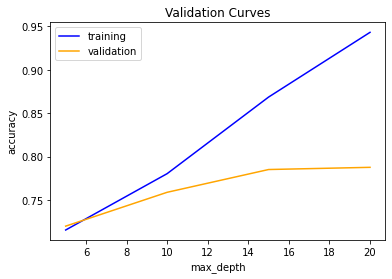

In [38]:
plt.plot(depths, train_acc, color='blue', label='training')
plt.plot(depths, val_acc, color='orange', label='validation')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.title('Validation Curves')
plt.legend()
plt.show()

#Build `RandomForestClassifier` model 

- Use pipeline
- Fit model to train/val data sets

In [39]:
model_rf = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    StandardScaler(),
    RandomForestClassifier(random_state=42, n_jobs=-1,bootstrap=True,max_depth=20,
                           max_features='auto',n_estimators=100, criterion='gini',
                           min_samples_split=2, min_samples_leaf=1,
                           min_weight_fraction_leaf=0.0, max_leaf_nodes=None, 
                           min_impurity_decrease=0.0, min_impurity_split=None, 
                           oob_score=False, verbose=0, warm_start=False, 
                           class_weight=None, ccp_alpha=0.0, max_samples=None)
)
model_rf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['basin', 'region', 'scheme_management',
                                      'extraction_type',
                                      'extraction_type_group',
                                      'extraction_type_class', 'management',
                                      'management_group', 'payment',
                                      'payment_type', 'water_quality',
                                      'quality_group', 'quantity', 'source',
                                      'source_type', 'source_class',
                                      'waterpoint_type',
                                      'waterpoint_type_group']...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=20, max_features='auto',
                                    

#Check Random Forest Metrics

- print accuracy scores for training/val

In [40]:
print('model_rf accuracy score for training:', accuracy_score(y_train, model_rf.predict(X_train)))
print('model_rf accuracy score for val:', accuracy_score(y_val, model_rf.predict(X_val)))
#model_rf accuracy score for training: 0.9617003367003367
#model_rf accuracy score for val: 0.8251262626262627

model_rf accuracy score for training: 0.9617529461279462
model_rf accuracy score for val: 0.8247053872053872


**Check cross-validation scores**

In [41]:
cv_scores_rf = cross_val_score(model_rf, X, y, cv=5,n_jobs=-1)

In [42]:
print('CV score RandomForestClassifier')
print(cv_scores_rf)
print('Mean CV accuracy score:', cv_scores_rf.mean())
print('STD CV accuracy score:', cv_scores_rf.std())
#Mean CV accuracy score: 0.8204545454545453

CV score RandomForestClassifier
[0.81691919 0.81986532 0.82123316 0.82680976 0.81744529]
Mean CV accuracy score: 0.8204545454545453
STD CV accuracy score: 0.003546733927783386


#Tune `RandomForestClassifier` model

In [43]:
clf = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    StandardScaler(),
    RandomForestClassifier(random_state=42, n_jobs=-1,bootstrap=True,max_depth=10,
                           max_features='auto',n_estimators=100, criterion='gini',
                           min_samples_split=2, min_samples_leaf=1,
                           min_weight_fraction_leaf=0.0, max_leaf_nodes=None, 
                           min_impurity_decrease=0.0, min_impurity_split=None, 
                           oob_score=False, verbose=0, warm_start=False, 
                           class_weight=None, ccp_alpha=0.0, max_samples=None)
)


param_grid = {
    'simpleimputer__strategy': ['median'],
    'randomforestclassifier__max_depth': range(10, 40, 10),
    'randomforestclassifier__n_estimators': range(50, 125, 50)
}

model_rfrs = RandomizedSearchCV(
    clf,
    param_distributions = param_grid,
    n_jobs=-1,
    cv=5,
    verbose=1,
    n_iter = 7
)

model_rfrs.fit(X,y)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 6 is smaller than n_iter=7. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.9min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('ordinalencoder',
                                              OrdinalEncoder(cols=None,
                                                             drop_invariant=False,
                                                             handle_missing='value',
                                                             handle_unknown='value',
                                                             mapping=None,
                                                             return_df=True,
                                                             verbose=0)),
                                             ('simpleimputer',
                                              SimpleImputer(add_indicator=False,
                                                            copy=True,
                                                            fill_value=None,


Print model's best parameters

In [44]:
model_rfrs.best_params_

{'randomforestclassifier__max_depth': 20,
 'randomforestclassifier__n_estimators': 100,
 'simpleimputer__strategy': 'median'}

Print best score for model_rfrs

In [45]:
model_rfrs.best_score_
#0.8216961279461279

0.8216961279461279

#Communicate Results
**Show Feature Importance** 

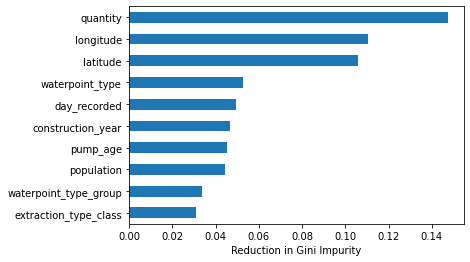

In [46]:
bestimator = model_rfrs.best_estimator_
importances = bestimator.named_steps['randomforestclassifier'].feature_importances_
features = X_train.columns
feat_imp = pd.Series(importances, index=features).sort_values()
feat_imp.tail(10).plot(kind='barh')
plt.xlabel('Reduction in Gini Impurity');

**Plot Confusion Matrix**

*Shows model's accuracy*

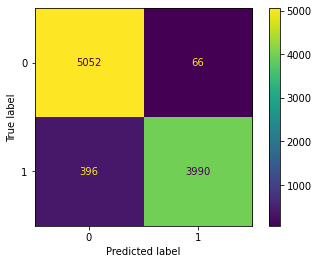

In [47]:
plot_confusion_matrix(
    model_rfrs,
    X_val,
    y_val,
    values_format = '.0f',
    
    
)

Print `ClassificationReport` to communicate Confusion Matrix results.

In [48]:
print(classification_report(y_val,
                      model_rfrs.predict(X_val),
                      target_names =['no repair needed','needs repair']))

                  precision    recall  f1-score   support

no repair needed       0.93      0.99      0.96      5118
    needs repair       0.98      0.91      0.95      4386

        accuracy                           0.95      9504
       macro avg       0.96      0.95      0.95      9504
    weighted avg       0.95      0.95      0.95      9504



#Make Submission

In [58]:
X_test = pd.read_csv('test_features.csv',
                              parse_dates=['date_recorded'])

In [59]:
X_test = wrangle(X_test)

In [60]:
model_rf.predict(X_test)

array([1, 0, 0, ..., 1, 1, 0])

In [61]:
prediction = pd.DataFrame(data=model_rf.predict(X_test), index=X_test.index)

In [62]:
prediction.columns = ['status_group']

In [63]:
prediction

,status_group
id,
37098,1
14530,0
62607,0
46053,1
47083,0
...,...
26092,0
919,1
47444,1


In [64]:
prediction.to_csv('OTTOLINO_WATER_PUMP_CHALLENGE.csv')

In [65]:
from google.colab import files
files.download("OTTOLINO_WATER_PUMP_CHALLENGE.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Save best trained model to reuse it in the future

In [57]:
import pickle
filename = 'Water_Pump_model_rfrs'

#save your model
pickle.dump(model_rf,open(filename,'wb'))
#load model
model_rfrs_loaded = pickle.load(open(filename,'rb'))

I merged my two training CSV's, thoroughly examined the data and then wrangled both the train and test data the exact same. There after, I experimented with a few models and picked the randomforestclassifier after running it through a RandomizedSearchCV. Once I did that, I saw that my confusion matrix was very accurate to verify my model was indeed the correct choice.